# Bernstein–Vazirani Problem

The Bernstein–Vazirani (BV) problem: given oracle access to a Boolean function
$$
f_a(x) = a \cdot x \oplus b,
$$
with unknown $a \in \{0,1\}^n$ and $b \in \{0,1\}$, recover the hidden string $a$ using as few queries as possible. Classically, determining $a$ in the worst case needs $n$ queries (probe each bit separately). Quantumly, BV recovers all $n$ bits of $a$ with **one oracle query**.

---

## Oracle

The standard oracle is a reversible unitary on $n+1$ qubits:
$$
U_f \, |x\rangle |y\rangle = |x\rangle \, |y \oplus f_a(x)\rangle,
$$
where $x \in \{0,1\}^n$ and $y \in \{0,1\}$. Preparing the target in $|-\rangle = (|0\rangle - |1\rangle)/\sqrt{2}$ turns $U_f$ into a **phase oracle** on the $n$-qubit register:
$$
U_f\big(|x\rangle \otimes |-\rangle\big) = (-1)^{f_a(x)} \, |x\rangle \otimes |-\rangle
= (-1)^{a \cdot x \oplus b} \, |x\rangle \otimes |-\rangle.
$$
The global phase $(-1)^b$ is irrelevant, so effectively the register picks up phase $(-1)^{a \cdot x}$.

**Circuit realization (common form):**
- For each $i$ with $a_i = 1$, apply a CNOT from input qubit $i$ to the ancilla.
- If $b = 1$, apply an $X$ to the ancilla (before or after the CNOTs).

---

## Algorithm

1. **Initialize**
   $$
   |0\rangle^{\otimes n} \otimes |1\rangle.
   $$

2. **Hadamards**
   Apply $H^{\otimes n}$ to the inputs and $H$ to the ancilla:
   $$
   |0\rangle^{\otimes n} \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} \sum_{x\in\{0,1\}^n} |x\rangle,
   \qquad
   |1\rangle \xrightarrow{H} |-\rangle.
   $$
   State:
   $$
   \frac{1}{\sqrt{2^n}} \sum_x |x\rangle \otimes |-\rangle.
   $$

3. **Oracle (phase kickback)**
   $$
   \frac{1}{\sqrt{2^n}} \sum_x (-1)^{a \cdot x \oplus b} |x\rangle \otimes |-\rangle
   \;\equiv\;
   \frac{(-1)^b}{\sqrt{2^n}} \sum_x (-1)^{a \cdot x} |x\rangle \otimes |-\rangle.
   $$

4. **Inverse Hadamards on inputs**
   Use the Walsh–Hadamard transform identity
   $$
   H^{\otimes n} \left( \frac{1}{\sqrt{2^n}} \sum_x (-1)^{a \cdot x} |x\rangle \right) = |a\rangle.
   $$
   The overall state becomes (up to a global phase) $|a\rangle \otimes |-\rangle$.

5. **Measurement**
   Measure the $n$ input qubits to obtain the hidden string $a$ **with probability 1** (in the ideal, noiseless setting). The ancilla can be ignored.

---

## Circuit Structure

- **Inputs:** $n$ qubits initialized to $|0\rangle^{\otimes n}$, **ancilla:** 1 qubit initialized to $|1\rangle$.
- Prepare: $X$ on ancilla, then Hadamard on all $(n+1)$ qubits.
- Apply the BV oracle $U_f$ (CNOTs from inputs with $a_i=1$ to the ancilla; optional $X$ on ancilla if $b=1$).
- Apply $H^{\otimes n}$ to inputs, measure only the $n$ input qubits.

---

## Notes and Variants

- The bit $b$ contributes only a **global phase** $(-1)^b$ after phase kickback and is therefore unobservable; BV recovers $a$ but not $b$.
- One can implement a **pure phase oracle** (no ancilla wire) directly as $|x\rangle \mapsto (-1)^{a\cdot x} |x\rangle$ using $Z$-type controls (e.g., $H$–CNOT–$H$ sandwiches), which leads to the same one-query algorithm without an explicit target qubit.
- In noisy or hardware-limited settings, transpilation may insert extra gates (e.g., SWAPs); the logical guarantee of one query still holds, but practical success probability will depend on device noise and circuit depth.



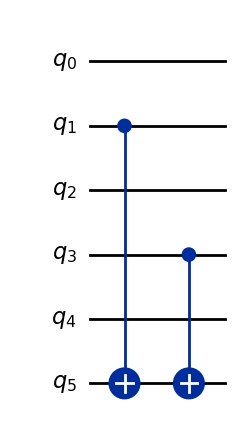

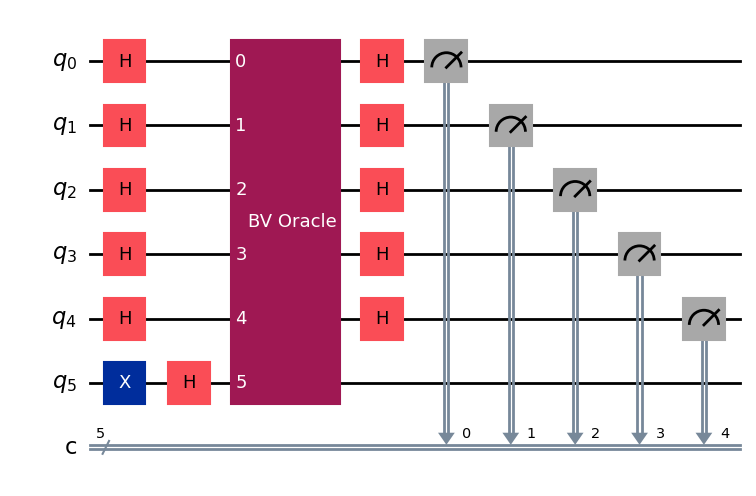

Counts: {'01010': 1024}


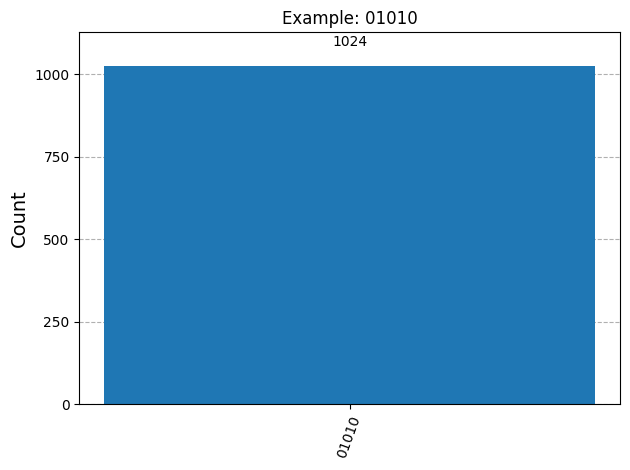

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# Deutsch-Josa algorithm circuit
def deutsch_josa_algorithm(oracle, n: int):
    qc = QuantumCircuit(n + 1, n)
    qc.x(n) # Initialize the ancilla qubit to |1>
    qc.h(list(range(n + 1))) # Apply Hadamard gates to all qubits
    qc.append(oracle, range(n + 1))  # Apply oracle
    qc.h(list(range(n))) # Apply Hadamard gates to all qubits
    qc.measure(range(n), range(n))
    return qc

# Berstein-Vazirani oracle generator
def berstein_vazirani_oracle(case: str, n: int):
    qc = QuantumCircuit(n + 1, name="BV Oracle")
    for i in range(len(case)):
        if case[i] == '1':
            qc.cx(i, n)
    return qc

# Example usage
n = 5  # Number of qubits
case = "01010"

oracle = berstein_vazirani_oracle(case, n)
qc = deutsch_josa_algorithm(oracle, n)
display(oracle.draw(output="mpl"))
display(qc.draw(output="mpl"))

# Run on simulator
sim = Aer.get_backend("aer_simulator")
tqc = transpile(qc, sim)
result = sim.run(tqc, shots = 1024).result()
counts = result.get_counts()
print("Counts:", counts)
plot_histogram(counts, title="Example: "+ case)

As, expected Deutsch-Josa circuit solves Berstein-Vazirani problem in one query and finds it with 100% accuracy.